# Genetic Algorithm Assignment
30% of the overall grade for this module

Marks indciated in sections below are based on percentage of marks allocated for this module

In this assignment you must choose a problem, and attempt to use the Genetic Alogrithm that we developed in class to solve this problem.





## The Problem         **(~30%)**

*   Description of the problem





---

(Double click then ...)  Type Here...

---



*   Discussion of the suitablity of Genetic Algorithms


---

(Double click then ...)  Type Here...

---



*   Complexity of the problem  (Overall marks allocated based on ..)

# The problem and the cost function   **(~20%)**

In [1]:
#imports
import numpy as np
from PIL import Image, ImageDraw

In [23]:
def cost_function(individual, target_image):
    return

def create_random_image(width, height):
    return np.random.randint(0, 255, (width, height, 3), dtype=np.uint8)

class problem:
    def __init__(self):
        self.width = 10
        self.height = 10
        self.number_of_genes = self.width * self.height
        self.cost_function = cost_function


# The Individual **(~30%)**


*   Chromosone
*   Crossover
*   Mutation



## Discussion and justification on the approaches taken for the above

---

(Double click then ...)  Type Here...

---



In [70]:
# Code for individual class in here


class individual:
    chromosome = None
    cost = None
    number_of_genes = None

    def __init__(self, prob):
        self.chromosome = create_random_image(prob.width, prob.height)
        self.number_of_genes = prob.number_of_genes
        
    def mutate(self, mutation_rate, mutation_range):
        for i in range (0, self.number_of_genes):
            random = np.random.uniform()
            if random < mutation_rate:
                row_to_mutate = np.random.randint(0, len(self.chromosome))
                pixel_to_mutate = np.random.randint(0, len(self.chromosome[row_to_mutate]))
              

                r_mutation = np.random.uniform(self.chromosome[row_to_mutate][pixel_to_mutate][0] - mutation_range, self.chromosome[row_to_mutate][pixel_to_mutate][0] + mutation_range)
            
                g_mutation = np.random.uniform(self.chromosome[row_to_mutate][pixel_to_mutate][1] - mutation_range, self.chromosome[row_to_mutate][pixel_to_mutate][1] + mutation_range)
             
                b_mutation = np.random.uniform(self.chromosome[row_to_mutate][pixel_to_mutate][2] - mutation_range, self.chromosome[row_to_mutate][pixel_to_mutate][2] + mutation_range)
               
                self.chromosome[row_to_mutate][pixel_to_mutate] = [r_mutation, g_mutation, b_mutation]
                
            
              

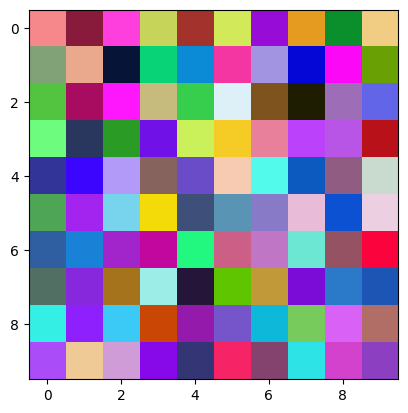

In [71]:
import matplotlib.pyplot as plt
p1 = problem()
ind1 = individual(p1)
img = Image.fromarray(ind1.chromosome, 'RGB')
plt.imshow(img)



mutating0.2668767581151288
mutating0.6381287000363021
mutating0.937696214742256
mutating0.32609200426248
mutating0.7034075548498737
mutating0.6589851634377238
mutating0.40429198966179203
mutating0.7775511495909687
mutating0.7727457022959912
mutating0.3382778085543564
mutating0.5397256288112191
mutating0.04840935544725333
mutating0.413562365813568
mutating0.9713683268035014
mutating0.2678387299417988
mutating0.5393588216094103
mutating0.7302339312729194
mutating0.7478923206674203
mutating0.06566505175780624
mutating0.5777117963887305
mutating0.5104252247778099
mutating0.04570439487672118
mutating0.3520316222280111
mutating0.7304851704985207
mutating0.8518846515585726
mutating0.7819975303917831
mutating0.26108291307343745
mutating0.7221087888293015
mutating0.9915807537317463
mutating0.47781115618613246
mutating0.4748510203842967
mutating0.7950508030571767
mutating0.9096286208860868
mutating0.4106585572491743
mutating0.5333791415067223
mutating0.49953733367934106
mutating0.864512068192974

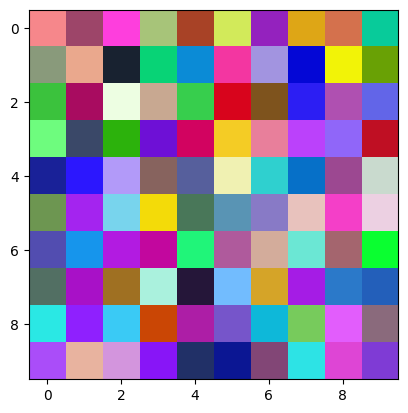

In [72]:

ind1.mutate(1, 25)
#draw the image 

img = Image.fromarray(ind1.chromosome, 'RGB')
#show the image as a pixel plot inside the notebook

plt.imshow(img)
plt.show()

## Running the algorithm  **(~10%)**

*   Parameter choices
*   Modifications (if any) to run_genetic
*   Rationale for the above



---

(Double click then ...)  Type Here...

---



In [ ]:
#  Parameter class here
class parameters:
  def __init__(self):
    self.population  = 1000
    self.number_of_generations = 100
    self.child_rate_per_generation = 1
    self.crossover_explore_rate = 0.5
    self.gene_mutate_rate = 0.2

In [ ]:
# Run Genetic method here

In [ ]:
#  Running of the algorithm with outputs here

In [ ]:
#  If changes to params or reruns of iterations dont overwrite, create more cells and copy code down to show evolution of final solution

## Results and conclusions    **(~10%)**

---

(Double click then ...)  Type Here...

---

